#What is Bayes Theorem?

Bayes theorem is what allows us to go from a **sampling (or likelihood) distribution** and a **prior distribution** to a **posterior distribution**.

##What is a Sampling Distribution?

A sampling distribution is the probability of seeing **our data (X)** given our **parameters ($\theta$).** This is written as $p(X|\theta)$.

For example, we might have data on 1,000 coin flips. Where 1 indicates a head. This can be represented in python as

In [2]:
import numpy as np
data_coin_flips = np.random.randint(2, size=1000)
np.mean(data_coin_flips)

0.46800000000000003

A sampling distribution allows us to specify how we think these data were generated. For our coin flips, we can think of our data as being generated from a [Bernoulli Distribution](http://en.wikipedia.org/wiki/Bernoulli_distribution). This distribution takes one **parameter** p which is the probability of getting a 1 (or a head for a coin flip). It then returns a value of 1 with probablility p and a value of 0 with probablility (1-p).

You can see how this is perfect for a coin flip. With a fair coin we know our p = .5 because we are equally likely to get a 1 (head) or 0 (tail). We can create samples from this distribution like this:

In [3]:
bernoulli_flips = np.random.binomial(n=1, p=.5, size=1000)
np.mean(bernoulli_flips)

0.46500000000000002

Now that we have defined how we believe our data were generated, we can calculate the probability of seeing our data given our parameters $p(X|\theta)$. Since we have selected a Bernoulli distribution, we only have one parameter: p. 

We can use the **probability mass function (PMF)** of the Bernoulli distribution to get our desired probability for a single coin flip. The PMF takes a single observed data point and then given the parameters (p in our case) returns the probablility of seeing that data point given those parameters. For a Bernoulli distribution it is simple: if the data point is a 1 the PMF returns p, if the data point is a 0 it returns (1-p). We could write a quick function to do this:

In [4]:
def bern_pmf(x, p):
    if (x == 1):
        return p
    elif (x == 0):
        return 1 - p
    else:
        return "Value Not in Support of Distribution"

We can now use this function to get the probability of a data point give our parameters. You probably see that with p = .5 this function always returns .5

In [5]:
print(bern_pmf(1, .5))
print(bern_pmf(0, .5))

0.5
0.5


This is a pretty simple PMF, but other distributions can get much more complicated. So it is good to know that Scipy has most of these built in. We can draw from the PMF as follows:

In [6]:
import scipy.stats as st
print(st.bernoulli.pmf(1, .5))
print(st.bernoulli.pmf(0, .5))

0.5
0.5


This is nice, but what we really want to know is the probability of see all 1,000 of our data points. How do we do that? The trick here is to assume that our data are [independent and identically distributed](http://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). This assumption allows us to say the probability of seeing all of our data is just the product of each individual probability: $p(x_{1}, ..., x_{n}|\beta) = p(x_{1}|\beta) * ... * p(x_{n}|\beta)$. This is easy to do:

In [7]:
np.product(st.bernoulli.pmf(data_coin_flips, .5))

9.3326361850321888e-302

How does that number help us? Well by itself, it doesn't really help too much. What we need to do now is get more of a distribution for our sampling model. Currently, we have only tested our model with p = .5, but what if p = .8? or .2? What would the probablility of our data look like then? This can be done by defining a grid of values for our p. Below I will make a grid of 100 values between 0 and 1 (because p has to be between 0 and 1) and then I will calculate the probability of seeing our data given each of these values:

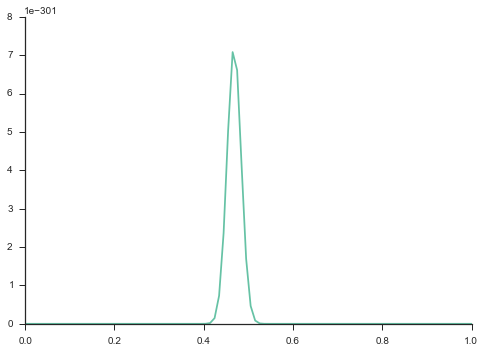

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='ticks', palette='Set2')

params = np.linspace(0, 1, 100)
p_x = [np.product(st.bernoulli.pmf(data_coin_flips, p)) for p in params]
plt.plot(params, p_x)
sns.despine()

Now we are getting somewhere. We can see that the probablility of seeing our data peaks at p=.5 and almost certainly is between p=.4 and p=.6. Nice. So now we have a good idea of what p value generated our data assuming it was drawn from a Bernoulli distribution. We're done, right? Not quite...

##Prior Distribution

Bayes theorem says that we need to think about both our sampling distribution and our prior distribution. What do I mean by prior distribution? It is the $p(\theta)$ or the probability of seeing a specific value for our parameter. In our sampling distribution we defined 100 values from 0 to 1 for our parameter p. Now we must define the prior probability of seeing each of those values. That is the probability we would have assumed before seeing any data. Most likely, we would have assumed a fair coin, which looks like the distribution above. Lets see how we can do this:

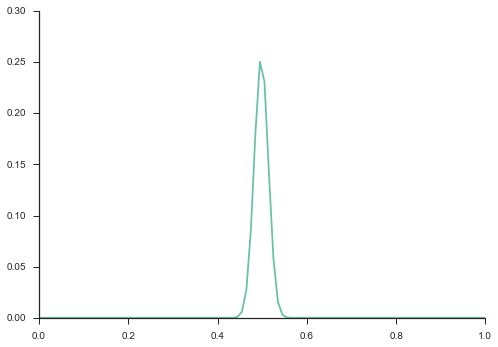

In [9]:
fair_flips = bernoulli_flips = np.random.binomial(n=1, p=.5, size=1000)
p_fair = np.array([np.product(st.bernoulli.pmf(fair_flips, p)) for p in params])
p_fair = p_fair / np.sum(p_fair)
plt.plot(params, p_fair)
sns.despine()

Basically we created 1,000 fair coin flips and then generated the sampling distribution like we did before (except we divided by the sum of the sampling distribution to make the values sum to 1). Now we have a "fair coin" prior on our parameters. This basically means that before we saw any data we thought coin flips were fair. And we can see that assumption in our prior distribution by the fact that our prior distribution peaks at .5 and is almost all between .4 and .6.

I know what you are thinking - this is pretty boring. The sampling and prior distributions look exactly the same. So lets mix things up. Lets keep our fair prior but change our data to be an unfair coin:

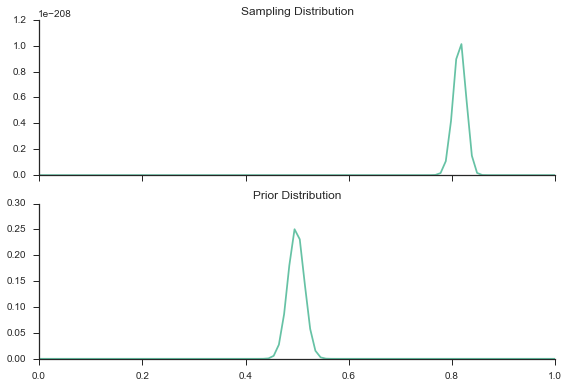

In [27]:
unfair_flips = bernoulli_flips = np.random.binomial(n=1, p=.8, size=1000)
p_unfair = np.array([np.product(st.bernoulli.pmf(unfair_flips, p)) for p in params])
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(params, p_unfair)
axes[0].set_title("Sampling Distribution")
axes[1].plot(params, p_fair)
axes[1].set_title("Prior Distribution")
sns.despine()
plt.tight_layout()

Ah - now this is interesting. We have strong data evidence of an unfair coin (since we generated the data we know it is unfair with p=.8), but our prior beliefs are telling us that coins are fair. How do we deal with this?

#Bayes Theorem (Posterior Distribution)

Bayes theorem is what allows us to go from our sampling and prior distributions to our posterior distribution. The **posterior distribution is the $P(\theta|X)$**. Or in English, the probability of our parameters given our data. And if you think about it that is what we really want. We are typically given our data - from maybe a survey or web traffic - and we want to figure out what parameters are most likely given our data. So how do we get to this posterior distribution? Here comes some math (don't worry it is not too bad):

By definition, we know that (If you don't believe me, check out this [page](https://people.richland.edu/james/lecture/m170/ch05-cnd.html) for a refresher): 
* $P(A|B) = \dfrac{P(A,B)}{P(B)}$. Or in English, the probability of seeing A given B is the probability of seeing them both divided by the probability of B.
* $P(B|A) = \dfrac{P(A,B)}{P(A)}$. Or in English, the probability of seeing B given A is the probability of seeing them both divided by the probability of A.

You will notice that both of these values share the same numerator, so:
* $P(A,B) = P(A|B)*P(B)$
* $P(A,B) = P(B|A)*P(A)$

Thus:

$P(A|B)*P(B) = P(B|A)*P(A)$

Which implies:

$P(A|B) = \dfrac{P(B|A)*P(A)}{P(B)}$

And plug in $\theta$ for $A$ and $X$ for $B$:

$P(\theta|X) = \dfrac{P(X|\theta)*P(\theta)}{P(X)}$

Nice! Now we can plug in some terminology we know:

$Posterior = \dfrac{likelihood * prior}{P(X)}$

But what is the $P(X)$? Or in English, the probability of our data? That sounds wierd... Let's go back to some math and use $B$ and $A$ again:

We know that $P(B) = \sum_{A} P(A,B)$ (check out this [page](http://en.wikipedia.org/wiki/Marginal_distribution) for a refresher)

And from our definitions above, we know that:

$P(A,B) = P(B|A)*P(A)$

Thus:

$P(B) = \sum_{A} P(B|A)*P(A)$

Plug in our $\theta$ and $X$:

$P(X) = \sum_{\theta} P(X|\theta)*P(\theta)$

Plug in our terminology:

$P(X) = \sum_{\theta} likelihood * prior$

Wow! Isn't that awesome! But what do we mean by $\sum_{\theta}$. This means to sum over all the values of our parameters. In our coin flip example, we defined 100 values for our parameter p, so we would have to calculated the likelihood * prior for each of these values and sum all those anwers. That is our denominator for Bayes Theorem. Thus our final answer for Bayes is:

$Posterior = \dfrac{likelihood * prior}{\sum_{\theta} likelihood * prior}$

That was a lot of text. Let's do some more coding and put everything together.

In [29]:
def bern_post(n_params=100, n_sample=100, true_p=.8, prior_p=.5, n_prior=100):
    params = np.linspace(0, 1, n_params)
    sample = np.random.binomial(n=1, p=true_p, size=n_sample)
    likelihood = np.array([np.product(st.bernoulli.pmf(sample, p)) for p in params])
    #likelihood = likelihood / np.sum(likelihood)
    prior_sample = np.random.binomial(n=1, p=prior_p, size=n_prior)
    prior = np.array([np.product(st.bernoulli.pmf(prior_sample, p)) for p in params])
    prior = prior / np.sum(prior)
    posterior = [prior[i] * likelihood[i] for i in range(prior.shape[0])]
    posterior = posterior / np.sum(posterior)
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    axes[0].plot(params, likelihood)
    axes[0].set_title("Sampling Distribution")
    axes[1].plot(params, prior)
    axes[1].set_title("Prior Distribution")
    axes[2].plot(params, posterior)
    axes[2].set_title("Posterior Distribution")
    sns.despine()
    plt.tight_layout()
    
    return posterior

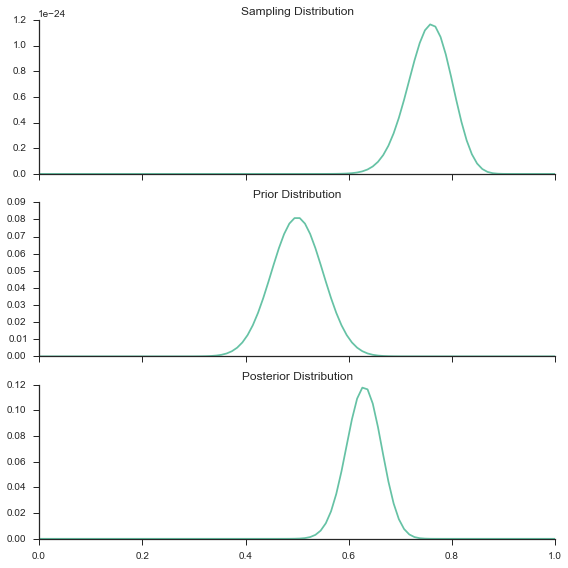

In [25]:
example_post = bern_post()

You will notice that I set 100 as the number of observations for the prior and likelihood. This increases the variance of our distributions. More data typically decreases the spread of a distribution. Also, as you get more data to estimate your likelihood, the prior distribution matters less. 

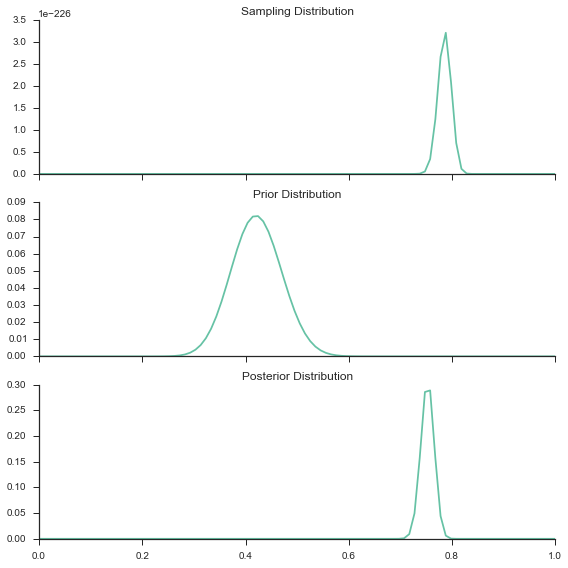

In [30]:
moredata_post = bern_post(n_sample=1000)

You can see that effect in the graphs above. Because we have more data to help us estimate our likelihood our posterior distribution is closer to our likelihood. Pretty cool.

##Conclusion

There you have it. An introduction to Bayes Theorem. Now if you ever are doubting the fairness of a coin you know how to investigate that problem! Or maybe the probability of a population voting yes for a law? Or any other yes/no outcome. I know what you are thinking - not that impressive. You want to predict things or run a fancy algorithm... in time my friends. I actually would like to write a series of posts leading up to Bayesian Linear Regression. Hopefully this is the first post in that series :)

###Some Side Notes

1. You will notice that the denominator for Bayes Theorem is just a constant. So if you only want to get the maximum posterior value, you don't even need to calculate that constant. For this reason you will often see the posterior shown as proportional (or $\propto$ in math) to the likelihood * prior.
2. Frequentist statistics is focused on the likelihood. Or you could say that frequentists are bayesians with a non-informative prior (like a uniform distribution). But don't hate on frequentists too much; most of bayesian inference in applied settings relies of frequentists statistics.
3. Now that you know frequentist statistics focuses on the likelihood it is much clearer why people often misinterpret frequentist confidence intervals. The likelihood is $P(X|\theta)$ - or the probability of our data given our parameters. That is a bit wierd because we are given our data, not our parameters. What most frequentists models do is take the maximum of the likelihood distribution (or Maximum Likelihood Estimation (MLE)). Basically find what parameters maximize the probability of seeing our data. The important point here is that they are treating the data as random, so what the frequentist confidence interval is saying is that if you were to keep getting new data (maybe some more surveys) and calculate confidence intervals on each of these new samples, 95% of these samples would have confidence intervals that contain the true parameter you are trying to estimate.